The SVHN dataset: download and pre-processing
==========================

A good description of the dataset is given on the official website:

*SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.*

The SVHN dataset can be downloaded from http://ufldl.stanford.edu/housenumbers/ The train file (in .mat format) has a total size of 174 MB, whereas the test file has a size of 64 MB. Here we are going to use only the MNIST-like 32-by-32 images centered around a single character. To load and use the MAT files we are gonna use Scipy.

From MAT to TFRecord format
-------------------------------------

In this session I will show you how to convert the MAT file format used to store the dataset, to the TFRecord format used in tensorflow. First of all we need to import our modules:

In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as sio

Here I will use Scipy to load the binary file in memory. It is necessary to have the MAT files in the same folder of this notebook. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). Using the method `type()` we can verify that bot features and labels are numpy arrays:

In [2]:
train_mat = sio.loadmat('./train_32x32.mat')
train_labels_array = train_mat["y"]
print(type(train_labels_array))
print(train_labels_array.shape)
train_images_array = train_mat["X"]
train_images_array = np.swapaxes(train_images_array, 2, 3) #[32, 32, 3, None] > [32, 32, None, 3]
train_images_array = np.swapaxes(train_images_array, 1, 2) #[32, 32, None, 3] > [32, None, 32, 3]
train_images_array = np.swapaxes(train_images_array, 0, 1) #[32, None, 32, 3] > [None, 32, 32, 3]
train_images_array = np.reshape(train_images_array, [73257, 32*32*3])
print(type(train_images_array))
print(train_images_array.shape)

<type 'numpy.ndarray'>
(73257, 1)
<type 'numpy.ndarray'>
(73257, 3072)


In [6]:
test_mat = sio.loadmat('./test_32x32.mat')
test_labels_array = test_mat["y"]
print(type(test_labels_array))
print(test_labels_array.shape)
test_images_array = test_mat["X"]
test_images_array = np.swapaxes(test_images_array, 2, 3) #[32, 32, 3, None] > [32, 32, None, 3]
test_images_array = np.swapaxes(test_images_array, 1, 2) #[32, 32, None, 3] > [32, None, 32, 3]
test_images_array = np.swapaxes(test_images_array, 0, 1) #[32, None, 32, 3] > [None, 32, 32, 3]
test_images_array = np.reshape(test_images_array, [26032, 32*32*3])
print(type(test_images_array))
print(test_images_array.shape)

<type 'numpy.ndarray'>
(26032, 1)
<type 'numpy.ndarray'>
(26032, 3072)


Now we can try to visualise an image from the dataset:

[4]


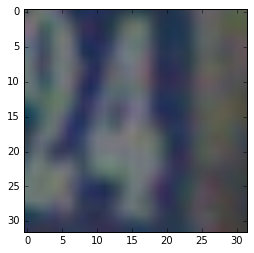

[7]


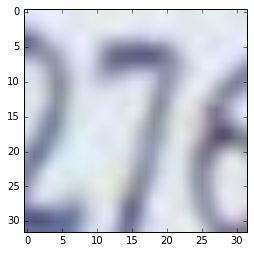

In [11]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

random_int = np.random.randint(0,train_images_array.shape[0])
image = train_images_array[random_int,:]
image = np.reshape(image, [32,32,3])
label = train_labels_array[random_int]
print(label)
plt.imshow(image)
plt.show()

random_int = np.random.randint(0,test_images_array.shape[0])
image = test_images_array[random_int,:]
image = np.reshape(image, [32,32,3])
label = test_labels_array[random_int]
print(label)
plt.imshow(image)
plt.show()

Now it is necessary to create a **TFRecord** file that we can easily use in Tensorflow. We can do it using the following function:

In [12]:
def numpy_to_tfrecord(images_array, labels_array, output_file):
    with tf.python_io.TFRecordWriter(output_file) as record_writer:
            for i in range(labels_array.shape[0]):
                #Getting the data as train feature
                bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[images_array[i].tobytes()]))
                int64_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[labels_array[i]]))
                #Stuff the data in an Example buffer
                example = tf.train.Example(features=tf.train.Features(feature={'image': bytes_feature,
                                                                               'label': int64_feature}))
                #Serialize example to string and write in tfrecords
                record_writer.write(example.SerializeToString())

In [13]:
numpy_to_tfrecord(test_images_array, test_labels_array, "./svhn_test.tfrecord")

In [14]:
numpy_to_tfrecord(train_images_array, train_labels_array, "./svhn_train.tfrecord")

From TFRecors to Tensorflow Dataset
-----------------------------------------

The two TFRecord files are ready to be used. Like for the CIFAR-10 tutorial we are gonna use the class `tf.data.TFRecordDataset` in order to manipulate the images. Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the `tf.data.Dataset` object. For example, you can apply per-element transformations such as `Dataset.map()` (to apply a function to each element), and multi-element transformations such as `Dataset.batch()`.

The `Dataset.map()` method takes as input a **parse function** that takes each single image and labels and adjust them. Here the image is converted back to `uint8` data type (because TFRecord stored the image as string) and the label is converted from a single integer representing the class to a one-hot vector that can be used in classification models.

In [15]:
def _parse_function(example_proto):
    features = {"image": tf.FixedLenFeature((), tf.string, default_value=""),
                "label": tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example_proto, features)
    image_decoded = tf.decode_raw(parsed_features["image"], tf.uint8) #char -> uint8
    image_reshaped = tf.reshape(image_decoded, [32, 32, 3])
    label_one_hot = tf.one_hot(parsed_features["label"], depth=10)
    return image_reshaped, label_one_hot

print "Loading the datasets..."
tf_train_dataset = tf.data.TFRecordDataset("./svhn_train.tfrecord")
print "Parsing the datasets..."
tf_train_dataset = tf_train_dataset.map(_parse_function)
print "Verifying types and shapes..."
print(tf_train_dataset.output_types)
print(tf_train_dataset.output_shapes)

Loading the datasets...
Parsing the datasets...
Verifying types and shapes...
(tf.uint8, tf.float32)
(TensorShape([Dimension(32), Dimension(32), Dimension(3)]), TensorShape([Dimension(10)]))


Using the Tensorflow Dataset in a session
-------------------------------------------------

Now the tensorflow datasets have been created and they are ready to be used in a session. The most common way to consume values from a Dataset is to make an **iterator** object that provides access to one element of the dataset at a time. A **one-shot iterator** is the simplest form of iterator, which only supports iterating once through a dataset, with no need for explicit initialization. Here I define a tensorflow iterator that can be used in our session, the size of the bacth, and the number of epochs.

In [16]:
with tf.name_scope('dataset'):
    batch_size = 32
    num_epochs = 5
    tf_train_dataset = tf_train_dataset.batch(batch_size)
    tf_train_dataset = tf_train_dataset.repeat(num_epochs)
    iterator = tf_train_dataset.make_one_shot_iterator()
    next_batch_imgs, next_batch_labels = iterator.get_next()

The `Iterator.get_next()` method returns one or more `tf.Tensor` objects that correspond to the symbolic next element of an iterator. If the iterator reaches the end of the dataset, executing the `Iterator.get_next()` operation will raise a `tf.errors.OutOfRangeError`. After this point the iterator will be in an unusable state, and you must initialize it again if you want to use it further. A common pattern is to wrap the "training loop" in a try-except block:

```
while True:
  try:
    sess.run(result)
  except tf.errors.OutOfRangeError:
    break
```
Now I define a new session and then I ask for a new batch of images and labels. Every time that the `sess.run()` is called a new batch is returned...

In [17]:
sess = tf.Session()

In [24]:
features, labels = sess.run([next_batch_imgs, next_batch_labels])

We can sample a random image and the one-hot label from the batch, and visualize them through matplotlib...

Label value: 6
One-hot-vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Batch shape: (32, 32, 32, 3)


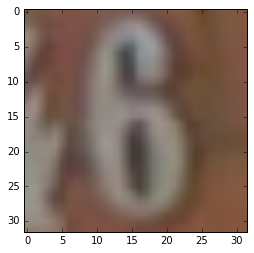

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
random_int = np.random.randint(0, 32)
image = features[random_int,:,:,:]
label = labels[random_int]
print "Label value: " + str(np.argmax(label))
print "One-hot-vector: " + str(label)
print "Batch shape: " + str(features.shape)
plt.imshow(image)
plt.show() 